In [1]:
import pandas, copy

from tqdm import tqdm

import statsmodels.api as sm

from src.utils import build_exact_table, build_bootstrapped_table, create_predictions_table, plot_truthtables, plot_growth_boxplot

%load_ext autoreload
%autoreload 2

In [2]:
who_drugs = list(pandas.read_csv('dat/drugs/who2_drugs.csv').drug)
plate_drugs = list(pandas.read_csv('dat/drugs/plate_drugs.csv').drug)
other_drugs = list(pandas.read_csv('dat/drugs/other_drugs.csv').drug)
mgit_drugs = list(pandas.read_csv('dat/drugs/mgit_drugs.csv').drug)

drug_names_table = pandas.read_csv("dat/drugs/drug_names_lookup.csv")
drug_names_table.set_index("DRUG", inplace=True)
drug_names_lookup = {}
for idx, row in drug_names_table.iterrows():
    drug_names_lookup[idx] = row.DRUG_NAME.capitalize()

In [3]:
PHENOTYPES = pandas.read_csv('dat/PHENOTYPES.csv')
PHENOTYPES.set_index(['ENA_RUN_ACCESSION', 'DRUG'], inplace=True)
PHENOTYPES.sort_index(inplace=True)
PHENOTYPES[:2]

UNIQUEID  \
ENA_RUN_ACCESSION DRUG                                                 
ERR13286038       BDQ   site.10.subj.LA00559418.lab.LA00559418.iso.1   
                  LZD   site.10.subj.LA00559418.lab.LA00559418.iso.1   

                       BINARY_PHENOTYPE PHENOTYPE_QUALITY PHENOTYPE_METHOD  
ENA_RUN_ACCESSION DRUG                                                      
ERR13286038       BDQ                 R               NaN             MGIT  
                  LZD                 S               NaN             MGIT

In [4]:
RAW_PREDICTIONS = pandas.read_csv('dat/RAW_PREDICTIONS.csv')
RAW_PREDICTIONS.set_index(['ENA_RUN_ACCESSION', 'DRUG'], inplace=True)
RAW_PREDICTIONS[:3]

PREDICTION
ENA_RUN_ACCESSION DRUG           
ERR4829376        AMI           S
                  BDQ           S
                  CAP           S

In [5]:
RAW_EFFECTS = pandas.read_csv('dat/RAW_EFFECTS.csv')
RAW_EFFECTS.set_index(['ENA_RUN_ACCESSION', 'DRUG'], inplace=True)
RAW_EFFECTS.sort_index(inplace=True)
print(f"There are {RAW_EFFECTS.IS_NULL.sum()} null calls and {RAW_EFFECTS.IS_MINOR_ALLELE.sum()} minor allele calls in the main effects table")
RAW_EFFECTS[:3]

There are 375 null calls and 1057 minor allele calls in the main effects table


GENE      MUTATION PREDICTION  EPISTASIS  \
ENA_RUN_ACCESSION DRUG                                               
ERR13286038       BDQ   Rv0678  138_ins_g:36          S      False   
                  CAP     tlyA          L11L          S      False   
                  CFZ   Rv0678  138_ins_g:36          S      False   

                        IS_MINOR_ALLELE  IS_NULL  
ENA_RUN_ACCESSION DRUG                            
ERR13286038       BDQ              True    False  
                  CAP             False    False  
                  CFZ              True    False

Most of the null calls are in the *rrs* gene so will affect the aminoglycosides

In [6]:
RAW_EFFECTS[RAW_EFFECTS.IS_NULL].GENE.value_counts()

GENE
rrs       328
rpoB       19
pncA        8
Rv0678      4
embB        4
gid         2
fabG1       2
gyrB        2
tlyA        2
rplC        2
ethA        1
katG        1
Name: count, dtype: int64

Whilst there are over 50 minor allele calls in genes that could affect resistance prediction for the fluorouinolones, rifampicin, bedaquline, pyrazinamide and ethambutol.

In [7]:
RAW_EFFECTS[RAW_EFFECTS.IS_MINOR_ALLELE].GENE.value_counts()[:15]

GENE
gyrA      244
rrs       184
Rv0678    160
rpoB      102
pncA       74
fabG1      54
embB       51
gid        47
gyrB       36
katG       25
eis        20
rpsL       17
ethA       14
rplC       13
rrl         9
Name: count, dtype: int64

Let's now build three EFFECTS tables that progressively include these nuances and from these build three PREDICTIONS tables that we can analyse by joining to PHENOTYPES

In [8]:
EFFECTS={}
EFFECTS[1] = copy.deepcopy(RAW_EFFECTS[~(RAW_EFFECTS.IS_MINOR_ALLELE) & ~(RAW_EFFECTS.IS_NULL)])
EFFECTS[1]['SET'] = 'basic'
EFFECTS[2] = copy.deepcopy(RAW_EFFECTS[~(RAW_EFFECTS.IS_MINOR_ALLELE)])
EFFECTS[2]['SET'] = 'nulls'
EFFECTS[3] = copy.deepcopy(RAW_EFFECTS)
EFFECTS[3]['SET'] = 'nulls+minors'
assert len(EFFECTS[3]) >  len(EFFECTS[2]) >  len(EFFECTS[1])

PREDICTIONS={}
for i in [1,2,3]:
    PREDICTIONS[i] = pandas.DataFrame(create_predictions_table(EFFECTS[i], who_drugs))

assert len(RAW_PREDICTIONS) == len(PREDICTIONS[1]) == len(PREDICTIONS[2]) == len(PREDICTIONS[3])

EFFECTS = pandas.concat(EFFECTS.values())
EFFECTS.reset_index(inplace=True)
EFFECTS.set_index(['SET','ENA_RUN_ACCESSION', 'DRUG'], inplace=True)
EFFECTS.to_csv('dat/EFFECTS.csv')

PREDICTIONS= pandas.concat(PREDICTIONS.values())
PREDICTIONS.to_csv('dat/PREDICTIONS.csv')

100%|██████████| 53398/53398 [00:01<00:00, 40876.10it/s]


These tables each contain three scenarios (i) `basic` which ignores all null and minor alleles and is therefore closest to the WHOv2 catalogue as written, (ii) `nulls` which makes an `F` call at genetic loci associated with resistance where there are insufficient reads (two or fewer) and (iii) `nulls+minors` which adds in calls where there are three or more reads supporting a resistance-associated variant.

In [9]:
EFFECTS[:2]

GENE MUTATION PREDICTION  EPISTASIS  \
SET   ENA_RUN_ACCESSION DRUG                                        
basic ERR13286038       CAP   tlyA     L11L          S      False   
                        DLM   fgd1    K270M          U      False   

                              IS_MINOR_ALLELE  IS_NULL  
SET   ENA_RUN_ACCESSION DRUG                            
basic ERR13286038       CAP             False    False  
                        DLM             False    False

In [10]:
PREDICTIONS[:2]

PREDICTION
SET   ENA_RUN_ACCESSION DRUG           
basic ERR13286038       INH           R
                        RIF           R

Let's check that has all worked, first by picking a sample and looking at its rows in an EFFECTS table

In [11]:
check_sample = 'ERR13286038'
effects = copy.deepcopy(EFFECTS)
effects.reset_index(inplace=True)
effects = effects[(effects.SET=='nulls') & (effects.ENA_RUN_ACCESSION==check_sample)]
effects.set_index(['ENA_RUN_ACCESSION', 'DRUG'], inplace=True)
effects

SET   GENE MUTATION PREDICTION  EPISTASIS  \
ENA_RUN_ACCESSION DRUG                                                
ERR13286038       CAP   nulls   tlyA     L11L          S      False   
                  DLM   nulls   fgd1    K270M          U      False   
                  EMB   nulls   embB    A409P          U      False   
                  EMB   nulls   embB    E405D          U      False   
                  ETH   nulls   ethA    Y211S          U      False   
                  ETH   nulls  fabG1    c-15t          R      False   
                  INH   nulls  fabG1    c-15t          R      False   
                  INH   nulls   katG    S315T          R      False   
                  LEV   nulls   gyrA     A90V          R      False   
                  LEV   nulls   gyrA     D94G          R      False   
                  LEV   nulls   gyrA     E21Q          S      False   
                  LEV   nulls   gyrA    G668D          S      False   
                  LEV   nulls   gyrA     S95T          S      False   
                  MXF   nulls   gyrA     A90V          R      False   
                  MXF   nulls   gyrA     D94G          R      False   
                  MXF   nulls   gyrA     E21Q          S      False   
                  MXF   nulls   gyrA    G668D          S      False   
                  MXF   nulls   gyrA     S95T          S      False   
                  PZA   nulls   pncA     H71Y          R      False   
                  RIF   nulls   rpoB    D103D          S      False   
                  RIF   nulls   rpoB    H445Y          R      False   
                  STM   nulls    gid    A134E          R      False   

                        IS_MINOR_ALLELE  IS_NULL  
ENA_RUN_ACCESSION DRUG                            
ERR13286038       CAP             False    False  
                  DLM             False    False  
                  EMB             False    False  
                  EMB             False    False  
                  ETH             False    False  
                  ETH             False    False  
                  INH             False    False  
                  INH             False    False  
                  LEV             False    False  
                  LEV             False    False  
                  LEV             False    False  
                  LEV             False    False  
                  LEV             False    False  
                  MXF             False    False  
                  MXF             False    False  
                  MXF             False    False  
                  MXF             False    False  
                  MXF             False    False  
                  PZA             False    False  
                  RIF             False    False  
                  RIF             False    False  
                  STM             False    False

Now compare that to the calculated per drug predictions

In [12]:
create_predictions_table(effects, who_drugs)

100%|██████████| 22/22 [00:00<00:00, 39349.55it/s]


PREDICTION
SET   ENA_RUN_ACCESSION DRUG           
nulls ERR13286038       INH           R
                        RIF           R
                        PZA           R
                        EMB           U
                        BDQ           S
                        LZD           S
                        MXF           R
                        LEV           R
                        CFZ           S
                        DLM           U
                        AMI           S
                        STM           R
                        ETH           R
                        KAN           S
                        CAP           S

Since we have a `RAW_PREDICTIONS` table parsed directly from the individual sample `json` files we can compare `PREDICTIONS['nulls+minors']` to that and they should be identical.

A direct way of doing that is to make an antibiogram for each sample (which will automatically be in alphabetical order of drug), and then look for samples where they are different.

In [13]:
def make_antibiogram(row):
    antibiogram=''
    for i in who_drugs:
        antibiogram += row[('PREDICTION',i)]
    return antibiogram

df1 = RAW_PREDICTIONS.unstack()
df1['ANTIBIOGRAM'] = df1.apply(make_antibiogram, axis=1)

PREDICTIONS.reset_index(inplace=True)
df2 = PREDICTIONS[PREDICTIONS.SET=='nulls+minors']
PREDICTIONS.set_index(['SET','ENA_RUN_ACCESSION', 'DRUG'], inplace=True)
df2.set_index(['ENA_RUN_ACCESSION', 'DRUG'], inplace=True)
df2=df2[['PREDICTION']].unstack()
# df2=df2.droplevel(0, axis=1)
df2['ANTIBIOGRAM'] = df2.apply(make_antibiogram, axis=1)

mask = (df1.ANTIBIOGRAM != df2.ANTIBIOGRAM)
assert len(df1[mask]) == 0, 'some samples have different antibiograms!'

Having the (alphabetical) antibiogram is useful, so let's calculate it for all three scenarios

In [14]:
df = PREDICTIONS.unstack()
df['ANTIBIOGRAM'] = df.apply(make_antibiogram, axis=1)
df = df[[('ANTIBIOGRAM','')]]
df = df.droplevel(1, axis=1)
df.reset_index(inplace=True)
df1 = df[df.SET=='basic']
df2 = df[df.SET=='nulls']
df3 = df[df.SET=='nulls+minors']
df1.set_index('ENA_RUN_ACCESSION', inplace=True)
df2.set_index('ENA_RUN_ACCESSION', inplace=True)
df3.set_index('ENA_RUN_ACCESSION', inplace=True)
df1 = df1.rename(columns={'SET':"SET1",'ANTIBIOGRAM':'ANTIBIOGRAM1'})
df2 = df2.rename(columns={'SET':"SET2",'ANTIBIOGRAM':'ANTIBIOGRAM2'})
df3 = df3.rename(columns={'SET':"SET3",'ANTIBIOGRAM':'ANTIBIOGRAM3'})
ANTIBIOGRAMS = df1.join(df2).join(df3)
ANTIBIOGRAMS.to_csv('dat/ANTIBIOGRAMS.csv')
ANTIBIOGRAMS[:3]

,SET1,ANTIBIOGRAM1,SET2,ANTIBIOGRAM2,SET3,ANTIBIOGRAM3
ENA_RUN_ACCESSION,,,,,,
ERR13286038,basic,RRRUSSRRSUSRRSS,nulls,RRRUSSRRSUSRRSS,nulls+minors,RRRUSSRRSUSRRSS
ERR13286039,basic,RSSSSSSSSSSSSSS,nulls,RSSSSSSSSSSSSSS,nulls+minors,RSSSRSSSRSSSSSS
ERR13286042,basic,RRRRSURRSSRRRRR,nulls,RRRRSURRSSRRRRR,nulls+minors,RRRRSURRSSRRRRR


We can now look to see how many samples out of 2,663 change between scenarios

In [15]:
print(f"Calling nulls at resistance loci changes the antibiogram of {(ANTIBIOGRAMS.ANTIBIOGRAM1!=ANTIBIOGRAMS.ANTIBIOGRAM2).sum()} samples,\
whilst also calling minor alleles leads to {(ANTIBIOGRAMS.ANTIBIOGRAM2!=ANTIBIOGRAMS.ANTIBIOGRAM3).sum()} samples changing antibiogram")

Calling nulls at resistance loci changes the antibiogram of 33 samples,whilst also calling minor alleles leads to 210 samples changing antibiogram


In [16]:
ANTIBIOGRAMS[ANTIBIOGRAMS.ANTIBIOGRAM1!=ANTIBIOGRAMS.ANTIBIOGRAM2]

,SET1,ANTIBIOGRAM1,SET2,ANTIBIOGRAM2,SET3,ANTIBIOGRAM3
ENA_RUN_ACCESSION,,,,,,
ERR13288807,basic,RRSSSSSSSSSSSSS,nulls,RRSSSSSSSSSFSSS,nulls+minors,RRSSSSSSSSSFSSS
ERR2510689,basic,RRRRSSSSSSSRRSS,nulls,RRRRSSSSSSFRRFF,nulls+minors,RRRRSSSSSSFRRFF
ERR2515400,basic,RRRRSUSSSRSSRSS,nulls,RRRRSUSSSRSFRSS,nulls+minors,RRRRSUSSSRSFRSS
ERR2515461,basic,SSSSSSUUSSSSSSS,nulls,SFSSSSUUSSSSSSS,nulls+minors,SFSSSSUUSSSSSSS
ERR2515574,basic,SSSSSSSSSSSSSSS,nulls,SFSSSSSSSSSSSSS,nulls+minors,SFSSSSSSSSSSSSS
ERR4796971,basic,SSSSSSSSSSSUUSS,nulls,SSSSSSSSSSSFUSS,nulls+minors,SSSSSSSSSSSFUSS
ERR4797493,basic,SSSSSSSSSUSSUSS,nulls,SFSSSSSSSUSSUSS,nulls+minors,SFSSSSSSSUSSUSS
ERR4798823,basic,RSSSSSSSSSSUSSS,nulls,RFFFFSSSSSFUFFF,nulls+minors,RFRRFSSSSSFUFFF
ERR4812546,basic,SSSSSSSSSUSSSSS,nulls,SSSSSSSSSUSFSSS,nulls+minors,SSSSSSSSSUSFSSS


In [17]:
results_drug_order = pandas.read_csv('dat/drugs/results_drugs.csv')
results_drug_order.set_index(['pDST method', 'drug'], inplace=True)
list(results_drug_order.index)

[('UKMYC', 'INH'),
 ('UKMYC', 'RIF'),
 ('MGIT', 'PZA'),
 ('UKMYC', 'EMB'),
 ('MGIT', 'BDQ'),
 ('UKMYC', 'LZD'),
 ('UKMYC', 'MXF'),
 ('UKMYC', 'LEV'),
 ('UKMYC', 'CFZ'),
 ('UKMYC', 'DLM'),
 ('UKMYC', 'AMI'),
 ('MGIT', 'STM'),
 ('UKMYC', 'ETH'),
 ('UKMYC', 'KAN'),
 ('MGIT', 'CAP')]

In [19]:
results={}
PREDICTIONS.reset_index(inplace=True)
PREDICTIONS.set_index(['ENA_RUN_ACCESSION', 'DRUG'], inplace=True)

for i in tqdm(['basic','nulls','nulls+minors']):
    
    predictions = PREDICTIONS[PREDICTIONS.SET==i]
    df = copy.deepcopy(predictions.join(PHENOTYPES, how='inner'))

    plate_df = df[df.PHENOTYPE_METHOD=='UKMYC']
    plate_df.reset_index(inplace=True)
    table = []
    table = build_exact_table(table, plate_df, plate_drugs, ['HIGH', 'ALL'], i, 'UKMYC', include_fails=False)
    table = build_bootstrapped_table(table,plate_df, plate_drugs, ['HIGH', 'ALL'], i, 'UKMYC', include_fails=False)

    mgit_df = df[df.PHENOTYPE_METHOD=='MGIT']
    mgit_df.reset_index(inplace=True)
    table = build_exact_table(table, mgit_df, mgit_drugs, ['ALL'], i, 'MGIT', include_fails=False)
    table = build_bootstrapped_table(table,mgit_df, mgit_drugs, ['ALL'], i, 'MGIT', include_fails=False)
    results[i] = pandas.DataFrame(table, columns=['set','drug','method','quality','dataset','sensitivity','sensitivity_sem','specificity','specificity_sem','PPV','PPV_sem', 'RR', 'SR', 'UR', 'RS', 'SS', 'US', 'Total'])

    results[i].set_index(['method','drug'],inplace=True)
    results[i] = results[i][results[i].index.isin(list(results_drug_order.index))]
    results[i].reset_index(inplace=True)
    results[i].drug = results[i].drug.astype('category')
    results[i].drug = results[i].drug.cat.set_categories(who_drugs)
    results[i].sort_values(['drug', 'dataset', 'quality'], inplace=True)
    results[i].set_index(['set','drug','method','dataset', 'quality'],inplace=True)

results = pandas.concat(results.values())
results.to_csv('dat/RESULTS.csv')
results


100%|██████████| 3/3 [00:19<00:00,  6.64s/it]


sensitivity  sensitivity_sem  \
set          drug method dataset        quality                                 
basic        INH  UKMYC  bootstrap-0    ALL         0.875912              NaN   
                                        HIGH        0.933852              NaN   
                         bootstrap-1    ALL         0.946360              NaN   
                                        HIGH        0.952000              NaN   
                         bootstrap-10   ALL         0.940000              NaN   
...                                                      ...              ...   
nulls+minors CAP  MGIT   bootstrap-7    ALL         0.748466              NaN   
                         bootstrap-8    ALL         0.788321              NaN   
                         bootstrap-9    ALL         0.736842              NaN   
                         bootstrapped50 ALL        74.983621         0.941786   
                         entire         ALL        75.098814         0.000000   

                                                 specificity  specificity_sem  \
set          drug method dataset        quality                                 
basic        INH  UKMYC  bootstrap-0    ALL         0.938053              NaN   
                                        HIGH        0.979424              NaN   
                         bootstrap-1    ALL         0.962343              NaN   
                                        HIGH        0.972000              NaN   
                         bootstrap-10   ALL         0.960000              NaN   
...                                                      ...              ...   
nulls+minors CAP  MGIT   bootstrap-7    ALL         0.982090              NaN   
                         bootstrap-8    ALL         0.983380              NaN   
                         bootstrap-9    ALL         0.993902              NaN   
                         bootstrapped50 ALL        98.295397         0.200364   
                         entire         ALL        98.254799         0.000000   

                                                       PPV   PPV_sem     RR  \
set          drug method dataset        quality                               
basic        INH  UKMYC  bootstrap-0    ALL       0.944882       NaN    NaN   
                                        HIGH      0.979592       NaN    NaN   
                         bootstrap-1    ALL       0.964844       NaN    NaN   
                                        HIGH      0.971429       NaN    NaN   
                         bootstrap-10   ALL       0.959184       NaN    NaN   
...                                                    ...       ...    ...   
nulls+minors CAP  MGIT   bootstrap-7    ALL       0.953125       NaN    NaN   
                         bootstrap-8    ALL       0.947368       NaN    NaN   
                         bootstrap-9    ALL       0.984375       NaN    NaN   
                         bootstrapped50 ALL      94.980289  0.593964    NaN   
                         entire         ALL      95.000000  0.000000  190.0   

                                                   SR   UR    RS     SS    US  \
set          drug method dataset        quality                                 
basic        INH  UKMYC  bootstrap-0    ALL       NaN  NaN   NaN    NaN   NaN   
                                        HIGH      NaN  NaN   NaN    NaN   NaN   
                         bootstrap-1    ALL       NaN  NaN   NaN    NaN   NaN   
                                        HIGH      NaN  NaN   NaN    NaN   NaN   
                         bootstrap-10   ALL       NaN  NaN   NaN    NaN   NaN   
...                                               ...  ...   ...    ...   ...   
nulls+minors CAP  MGIT   bootstrap-7    ALL       NaN  NaN   NaN    NaN   NaN   
                         bootstrap-8    ALL       NaN  NaN   NaN    NaN   NaN   
                         bootstrap-9    ALL       NaN  NaN   NaN    NaN   NaN   
                      

In [20]:
results.reset_index(inplace=True)

<Axes: >

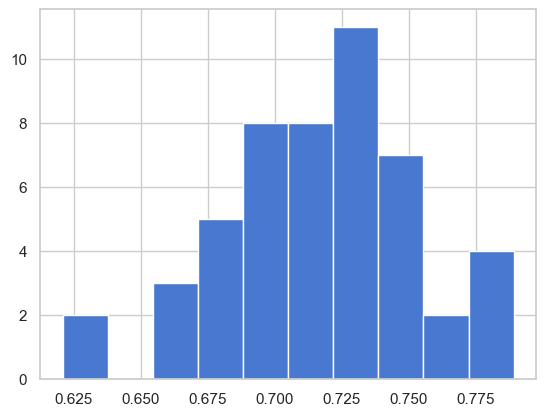

In [27]:
results[(results.set=='basic') & (results.drug=='AMI') & (results.dataset.str[:10]=='bootstrap-') & (results.quality=='ALL')].sensitivity.hist()

Now let's look at the number of Fail results when we allow these rules to contribute

In [19]:
EFFECTS.reset_index(inplace=True)
EFFECTS['GENE_MUTATION'] = EFFECTS.GENE + '_' + EFFECTS.MUTATION
print(f"There are {len(EFFECTS[(EFFECTS.SET=='nulls') & (EFFECTS.PREDICTION=='F')])} rows with a Fail call in the EFFECTS table (but these can be one variant affecting multiple drugs)")

df = EFFECTS[(EFFECTS.SET=='nulls') & (EFFECTS.PREDICTION=='F')]
df.set_index(['ENA_RUN_ACCESSION', 'GENE', 'MUTATION'], inplace=True)
print(f"Of the {len(df)} Fails, {df.index.duplicated().sum()} are duplicates")

df = df[~df.index.duplicated()]
df.reset_index(inplace=True)
print("And the most common genes are:")
df.GENE.value_counts()

There are 142 rows with a Fail call in the EFFECTS table (but these can be one variant affecting multiple drugs)
Of the 142 Fails, 17 are duplicates
And the most common genes are:


GENE
rrs       82
rpoB      19
pncA       8
embB       4
gid        2
Rv0678     2
tlyA       2
rplC       2
ethA       1
katG       1
fabG1      1
gyrB       1
Name: count, dtype: int64

Looking at which the RAVs most likely to be affected we can see how STM is affected more than AMI and KAN 

In [20]:
df.GENE_MUTATION.value_counts()[:5]

GENE_MUTATION
rrs_c517x     36
rrs_a514x     32
rrs_c1402x     6
rrs_a1401x     4
rrs_g1484x     4
Name: count, dtype: int64

In [21]:
results.reset_index(inplace=True)
df = results[(results.set=="nulls+minors") & (results.method=="UKMYC") & (results.dataset=="entire") & (results.quality=='HIGH')]
df.sort_values(by='Total')

,set,drug,method,dataset,quality,sensitivity,sensitivity_sem,specificity,specificity_sem,PPV,PPV_sem,RR,SR,UR,RS,SS,US,Total
135,nulls+minors,CFZ,UKMYC,entire,HIGH,5.128205,0.0,97.826087,0.0,23.529412,0.0,4.0,66.0,8.0,13.0,557.0,28.0,676.0
123,nulls+minors,LZD,UKMYC,entire,HIGH,42.857143,0.0,99.847561,0.0,96.428571,0.0,27.0,33.0,3.0,1.0,601.0,54.0,719.0
127,nulls+minors,MXF,UKMYC,entire,HIGH,89.743590,0.0,93.373494,0.0,86.419753,0.0,210.0,19.0,5.0,33.0,427.0,38.0,732.0
139,nulls+minors,DLM,UKMYC,entire,HIGH,20.634921,0.0,100.000000,0.0,100.000000,0.0,13.0,34.0,16.0,0.0,525.0,161.0,749.0
117,nulls+minors,EMB,UKMYC,entire,HIGH,89.035088,0.0,81.632653,0.0,67.218543,0.0,203.0,17.0,8.0,99.0,411.0,29.0,767.0
131,nulls+minors,LEV,UKMYC,entire,HIGH,86.973180,0.0,96.590909,0.0,92.653061,0.0,227.0,26.0,8.0,18.0,467.0,43.0,790.0
143,nulls+minors,AMI,UKMYC,entire,HIGH,83.673469,0.0,99.307958,0.0,98.086124,0.0,205.0,36.0,4.0,4.0,537.0,37.0,825.0
149,nulls+minors,ETH,UKMYC,entire,HIGH,76.377953,0.0,86.184211,0.0,69.784173,0.0,194.0,21.0,39.0,84.0,402.0,122.0,863.0
111,nulls+minors,RIF,UKMYC,entire,HIGH,96.590909,0.0,95.671982,0.0,95.720721,0.0,425.0,15.0,0.0,19.0,405.0,15.0,880.0
153,nulls+minors,KAN,UKMYC,entire,HIGH,84.615385,0.0,98.543689,0.0,96.069869,0.0,220.0,34.0,6.0,9.0,563.0,46.0,880.0


In [22]:
conditions = [  (('basic', 'ALL'), ('basic', 'HIGH')),
                (('basic', 'ALL'), ('nulls+minors', 'ALL')),
                (('basic', 'ALL'), ('nulls+minors', 'HIGH')),
                (('basic', 'HIGH'), ('nulls+minors', 'HIGH')),
                (('nulls+minors', 'ALL'), ('nulls+minors', 'HIGH')),
            ]

df = results[results.dataset=='entire']

statistical_rows = []

for i in conditions:
    a = df[(df.set==i[0][0]) & (df.quality==i[0][1])]
    b = df[(df.set==i[1][0]) & (df.quality==i[1][1])]
    for drug in a.drug.unique():
        
        row1 = a[a.drug==drug]
        row2 = b[b.drug==drug]

        if not row1.empty and not row2.empty:
            tab = []
            tab.append([int(row1.RR), int(row1.SR+row1.UR), ],)
            tab.append([int(row2.RR), int(row2.SR+row2.UR), ],)        
            st = sm.stats.StratifiedTable([tab])
            st_results=st.summary().data
            for st_line in st_results:
                if st_line[0]=='Test of OR=1':
                    sens_pvalue=float(st_line[2])
            
            tab = []
            tab.append([int(row1.SS), int(row1.RS), ],)
            tab.append([int(row2.SS), int(row2.RS), ],)        
            st = sm.stats.StratifiedTable([tab])
            st_results=st.summary().data
            for st_line in st_results:
                if st_line[0]=='Test of OR=1':
                    spec_pvalue=float(st_line[2])

            tab = []
            tab.append([int(row1.RR), int(row1.RS), ],)
            tab.append([int(row2.RR), int(row2.RS), ],)        
            st = sm.stats.StratifiedTable([tab])
            st_results=st.summary().data
            for st_line in st_results:
                if st_line[0]=='Test of OR=1':
                    ppv_pvalue=float(st_line[2])


            tab = []
            tab.append([int(row1.SS), int(row1.SR+row1.UR), ],)
            tab.append([int(row2.SS), int(row2.SR+row2.UR), ],)        
            st = sm.stats.StratifiedTable([tab])
            st_results=st.summary().data
            for st_line in st_results:
                if st_line[0]=='Test of OR=1':
                    npv_pvalue=float(st_line[2])

            statistical_rows.append([i[0][0], i[0][1], i[1][0], i[1][1], drug, sens_pvalue, spec_pvalue, ppv_pvalue, npv_pvalue])
        else:
            statistical_rows.append([i[0][0], i[0][1], i[1][0], i[1][1], drug, None, None, None, None])

/var/folders/dh/1k1mg9v14wd4bhfwdyhp5ygh0000gn/T/ipykernel_54473/3655671863.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  tab.append([int(row1.RR), int(row1.SR+row1.UR), ],)
/var/folders/dh/1k1mg9v14wd4bhfwdyhp5ygh0000gn/T/ipykernel_54473/3655671863.py:23: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  tab.append([int(row2.RR), int(row2.SR+row2.UR), ],)
/var/folders/dh/1k1mg9v14wd4bhfwdyhp5ygh0000gn/T/ipykernel_54473/3655671863.py:31: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  tab.append([int(row1.SS), int(row1.RS), ],)
/var/folders/dh/1k1mg9v14wd4bhfwdyhp5ygh0000gn/T/ipykernel_54473/3655671863.py:32: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in

In [23]:
statistical_table = pandas.DataFrame(statistical_rows, columns=['dataset1', 'quality1', 'dataset2', 'quality2', 'drug', 'sensitivity', 'specificity', 'PPV', 'NPV'])
statistical_table.to_csv('dat/RESULTS_STATISTICAL_SIGNIFICANCE.csv')
statistical_table

,dataset1,quality1,dataset2,quality2,drug,sensitivity,specificity,PPV,NPV
0,basic,ALL,basic,HIGH,INH,0.111,0.521,0.430,0.164
1,basic,ALL,basic,HIGH,RIF,0.472,0.525,0.354,0.704
2,basic,ALL,basic,HIGH,PZA,NaN,NaN,NaN,NaN
3,basic,ALL,basic,HIGH,EMB,0.386,0.149,0.547,0.677
4,basic,ALL,basic,HIGH,BDQ,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
66,nulls+minors,ALL,nulls+minors,HIGH,AMI,0.007,0.783,0.957,0.033
67,nulls+minors,ALL,nulls+minors,HIGH,STM,NaN,NaN,NaN,NaN
68,nulls+minors,ALL,nulls+minors,HIGH,ETH,0.200,0.628,0.864,0.440
69,nulls+minors,ALL,nulls+minors,HIGH,KAN,0.017,0.762,0.992,0.061


In [24]:
statistical_table[statistical_table.sensitivity<0.05]

,dataset1,quality1,dataset2,quality2,drug,sensitivity,specificity,PPV,NPV
10,basic,ALL,basic,HIGH,AMI,0.010,0.812,0.966,0.050
13,basic,ALL,basic,HIGH,KAN,0.028,0.791,0.993,0.100
29,basic,ALL,nulls+minors,ALL,CAP,0.015,0.993,0.779,0.051
30,basic,ALL,nulls+minors,HIGH,INH,0.014,0.955,0.862,0.030
35,basic,ALL,nulls+minors,HIGH,LZD,0.004,0.834,0.979,0.002
36,basic,ALL,nulls+minors,HIGH,MXF,0.007,0.384,0.898,0.070
37,basic,ALL,nulls+minors,HIGH,LEV,0.004,0.760,0.873,0.021
40,basic,ALL,nulls+minors,HIGH,AMI,0.001,0.520,0.708,0.008
43,basic,ALL,nulls+minors,HIGH,KAN,0.002,0.426,0.669,0.015
61,nulls+minors,ALL,nulls+minors,HIGH,LZD,0.047,0.744,0.694,0.007


In [25]:
statistical_table[statistical_table.specificity<0.05]

,dataset1,quality1,dataset2,quality2,drug,sensitivity,specificity,PPV,NPV


In [26]:
statistical_table[statistical_table.NPV<0.05]

,dataset1,quality1,dataset2,quality2,drug,sensitivity,specificity,PPV,NPV
5,basic,ALL,basic,HIGH,LZD,0.067,0.388,0.367,0.010
8,basic,ALL,basic,HIGH,CFZ,0.566,0.951,0.027,0.000
9,basic,ALL,basic,HIGH,DLM,0.116,0.371,0.395,0.000
30,basic,ALL,nulls+minors,HIGH,INH,0.014,0.955,0.862,0.030
35,basic,ALL,nulls+minors,HIGH,LZD,0.004,0.834,0.979,0.002
37,basic,ALL,nulls+minors,HIGH,LEV,0.004,0.760,0.873,0.021
38,basic,ALL,nulls+minors,HIGH,CFZ,0.566,0.785,0.018,0.000
39,basic,ALL,nulls+minors,HIGH,DLM,0.116,0.371,0.395,0.000
40,basic,ALL,nulls+minors,HIGH,AMI,0.001,0.520,0.708,0.008
43,basic,ALL,nulls+minors,HIGH,KAN,0.002,0.426,0.669,0.015


In [27]:
statistical_table[statistical_table.PPV<0.05]

,dataset1,quality1,dataset2,quality2,drug,sensitivity,specificity,PPV,NPV
8,basic,ALL,basic,HIGH,CFZ,0.566,0.951,0.027,0.0
38,basic,ALL,nulls+minors,HIGH,CFZ,0.566,0.785,0.018,0.0
64,nulls+minors,ALL,nulls+minors,HIGH,CFZ,0.392,0.936,0.016,0.0
